# Basic Example Notebook
Hello and welcome to `PauliPropagation.jl` - a Julia package for Pauli propagation simulation of quantum circuits and quantum systems.

That is, we estimate quantities like
$ Tr[\rho \ \mathcal{E}(\hat{O})] $
where $\rho$ is an initial state, $\mathcal{E}$ is a quantum channel that is not necessarily unitary, and $\hat{O}$ is an observable preferrably sparse in Pauli basis.

In the following we are going to introduce the basic concepts and datatypes of the package.

In [1]:
using PauliPropagation

Define the number of qubits in the simulation.

In [2]:
nq = 64

64

Now define the observable $\hat{O} = Z_{32} = I_1 \otimes ... \otimes I_{31} \otimes Z_{32} \otimes I_{33}... \otimes I_{62}$.

The `PauliString` type is our high-level way of handling Pauli strings. This above constructor defines a `PauliString` that has the only non-Identity Pauli at position 32.

This library uses encodes Paulis into the bits of Integers for performance reasons, and also actions of gates onto Paulis are defined as bit operations. You can definitely get by just sticking to the high level interface. Check out some other example notebooks for more involved code.

In [3]:
pstr = PauliString(nq, [:Z, :Z], [32, 33])

PauliString(nqubits: 64, 1.0 * IIIIIIIIIIIIIIIIIIII...)

Now we specify the circuit that we want to run. We provide some simple constructors for common circuit ansätze. Here we use a generic circuit ansatz called the `hardwareefficientcircuit`. It consists of repeated RX- RZ - RX Pauli rotation gates intertwined with RYY entangling gates.

For everything to work out, we need to specify the number of circuit layers and the entangling topology. By defailt we use the so-called 1D `bricklayertopology`, but you can customize a topology via an array or tuples like `[(1, 2), (1, 3), ...]`.

In [4]:
nl = 4
topology = bricklayertopology(nq; periodic=false)
circuit = hardwareefficientcircuit(nq, nl; topology=topology)
nparams = countparameters(circuit)

1020

This circuit has a total of 1020 Pauli rotation gates. Let us draw some random parameters from a narrow-ish Gaussian around zero.

In [5]:
using Random
Random.seed!(42)
thetas = randn(nparams) * 0.5;

Now we get to the interesting part. The propagation of the Observable `pstr` through `circuit`. In other words, we apply the circuit onto the Pauli string.

First, let us do it exactly.

In [6]:
@time psum = propagate(circuit, pstr, thetas)

  3.186119 seconds (476.50 k allocations: 94.067 MiB, 0.45% gc time, 14.42% compilation time)


PauliSum(nqubits: 64, 451751 Pauli terms:
 2.0753e-7 * IIIIIIIIIIIIIIIIIIII...
 -2.9492e-7 * IIIIIIIIIIIIIIIIIIII...
 3.2939e-7 * IIIIIIIIIIIIIIIIIIII...
 1.5265e-10 * IIIIIIIIIIIIIIIIIIII...
 7.0939e-7 * IIIIIIIIIIIIIIIIIIII...
 7.283e-10 * IIIIIIIIIIIIIIIIIIII...
 -4.4199e-9 * IIIIIIIIIIIIIIIIIIII...
 1.6939e-7 * IIIIIIIIIIIIIIIIIIII...
 2.0956e-10 * IIIIIIIIIIIIIIIIIIII...
 1.0387e-10 * IIIIIIIIIIIIIIIIIIII...
 -4.6963e-10 * IIIIIIIIIIIIIIIIIIII...
 -1.5167e-8 * IIIIIIIIIIIIIIIIIIII...
 -3.6059e-8 * IIIIIIIIIIIIIIIIIIII...
 -9.0411e-9 * IIIIIIIIIIIIIIIIIIII...
 -9.8434e-9 * IIIIIIIIIIIIIIIIIIII...
 3.8042e-7 * IIIIIIIIIIIIIIIIIIII...
 -1.405e-8 * IIIIIIIIIIIIIIIIIIII...
 -6.3381e-8 * IIIIIIIIIIIIIIIIIIII...
 -2.9495e-10 * IIIIIIIIIIIIIIIIIIII...
 2.1251e-9 * IIIIIIIIIIIIIIIIIIII...
  ⋮)

Just to run it again after Julia's jit-compilation:

In [7]:
@time propagate(circuit, pstr, thetas);

  2.810774 seconds (3.73 k allocations: 63.540 MiB, 0.69% gc time)


How is it possible that we can exactly run 64-qubit circuits? We leverage a concept referred to as the _entanglement lightcone_. But we don't do it manually, the Pauli propagation framework does it naturally. Still, we created over 160k Pauli strings in an object of type `PauliSum`. As the name suggests, this is a sum of Pauli strings. Be very mindful of the fact that the runtime will initially scale exponentially with the circuit depth!

The `psum` object may already be of interest of you. But here is a quick and easy way how to evaluate the expectation value if initial state is the zero-state, i.e. $\rho = |0\rangle\langle 0|$.

In [8]:
overlapwithzero(psum)

0.4044569657289259

Remember, this was an exact calculation. Well actually, our library has a default truncation threshold of Pauli strings with coefficients smaller than 1e-10. Here is how you control the minimum absolute coefficient threshold `min_abs_coeff`.

In [9]:
@time psum_exact = propagate(circuit, pstr, thetas; min_abs_coeff=0)

  3.273722 seconds (68.94 k allocations: 174.183 MiB, 0.73% gc time, 3.65% compilation time)


PauliSum(nqubits: 64, 692199 Pauli terms:
 2.0753e-7 * IIIIIIIIIIIIIIIIIIII...
 -2.9492e-7 * IIIIIIIIIIIIIIIIIIII...
 -1.6269e-12 * IIIIIIIIIIIIIIIIIIII...
 3.2939e-7 * IIIIIIIIIIIIIIIIIIII...
 1.5453e-10 * IIIIIIIIIIIIIIIIIIII...
 7.352e-11 * IIIIIIIIIIIIIIIIIIII...
 7.0939e-7 * IIIIIIIIIIIIIIIIIIII...
 6.6692e-10 * IIIIIIIIIIIIIIIIIIII...
 -4.4235e-9 * IIIIIIIIIIIIIIIIIIII...
 1.6939e-7 * IIIIIIIIIIIIIIIIIIII...
 2.0231e-10 * IIIIIIIIIIIIIIIIIIII...
 8.864e-11 * IIIIIIIIIIIIIIIIIIII...
 3.6934e-12 * IIIIIIIIIIIIIIIIIIII...
 -5.1191e-10 * IIIIIIIIIIIIIIIIIIII...
 4.7927e-12 * IIIIIIIIIIIIIIIIIIII...
 -1.5093e-8 * IIIIIIIIIIIIIIIIIIII...
 -3.6056e-8 * IIIIIIIIIIIIIIIIIIII...
 -9.0265e-9 * IIIIIIIIIIIIIIIIIIII...
 -9.8398e-9 * IIIIIIIIIIIIIIIIIIII...
 2.1516e-9 * IIIIIIIIIIIIIIIIIIII...
  ⋮)

And the expectation value is pretty much the same.

In [10]:
print("The error with our default truncation of `1e-10` is ", abs(overlapwithzero(psum_exact) - overlapwithzero(psum)))

The error with our default truncation of `1e-10` is 2.2824353518302587e-11

How about less strict truncation thresholds?

In [11]:
min_abs_coeff = 1e-3
@time psum_coeff = propagate(circuit, pstr, thetas; min_abs_coeff = min_abs_coeff)

  0.085595 seconds (55.53 k allocations: 5.152 MiB, 82.50% compilation time)


PauliSum(nqubits: 64, 1246 Pauli terms:
 -0.0010728 * IIIIIIIIIIIIIIIIIIII...
 -0.0064108 * IIIIIIIIIIIIIIIIIIII...
 -0.0070246 * IIIIIIIIIIIIIIIIIIII...
 0.0011246 * IIIIIIIIIIIIIIIIIIII...
 0.0012849 * IIIIIIIIIIIIIIIIIIII...
 -0.0026341 * IIIIIIIIIIIIIIIIIIII...
 0.001131 * IIIIIIIIIIIIIIIIIIII...
 -0.0014594 * IIIIIIIIIIIIIIIIIIII...
 -0.007123 * IIIIIIIIIIIIIIIIIIII...
 -0.0080756 * IIIIIIIIIIIIIIIIIIII...
 -0.0012613 * IIIIIIIIIIIIIIIIIIII...
 0.0024075 * IIIIIIIIIIIIIIIIIIII...
 0.0036905 * IIIIIIIIIIIIIIIIIIII...
 0.20173 * IIIIIIIIIIIIIIIIIIII...
 -0.0041127 * IIIIIIIIIIIIIIIIIIII...
 0.032178 * IIIIIIIIIIIIIIIIIIII...
 0.0033753 * IIIIIIIIIIIIIIIIIIII...
 -0.0017314 * IIIIIIIIIIIIIIIIIIII...
 0.0033265 * IIIIIIIIIIIIIIIIIIII...
 0.0034153 * IIIIIIIIIIIIIIIIIIII...
  ⋮)

In [12]:
print("The error with `min_abs_coeff = $min_abs_coeff` is ", abs(overlapwithzero(psum_exact) - overlapwithzero(psum_coeff)))

The error with `min_abs_coeff = 0.001` is 0.0026056759691825415

The expectation value is still surprisingly precise.

Another very general but powerful truncation is one based on _Pauli weight_. We can truncate Pauli strings that have many non-Identity Paulis, which has been proven to be a valid truncation for random circuits, but it also works well in practice. We can pass this as the keyword argument `max_weight`.

In [13]:
max_weight = 5
@time psum_weight = propagate(circuit, pstr, thetas; max_weight = max_weight)

  0.290100 seconds (67.93 k allocations: 11.661 MiB, 29.99% compilation time)


PauliSum(nqubits: 64, 23879 Pauli terms:
 -2.0464e-9 * IIIIIIIIIIIIIIIIIIII...
 -6.3913e-8 * IIIIIIIIIIIIIIIIIIII...
 -7.3028e-7 * IIIIIIIIIIIIIIIIIIII...
 3.4546e-9 * IIIIIIIIIIIIIIIIIIII...
 1.6556e-7 * IIIIIIIIIIIIIIIIIIII...
 -7.5073e-6 * IIIIIIIIIIIIIIIIIIII...
 9.8674e-10 * IIIIIIIIIIIIIIIIIIII...
 -1.9443e-8 * IIIIIIIIIIIIIIIIIIII...
 -3.2317e-6 * IIIIIIIIIIIIIIIIIIII...
 -6.72e-6 * IIIIIIIIIIIIIIIIIIII...
 1.2658e-5 * IIIIIIIIIIIIIIIIIIII...
 1.1673e-7 * IIIIIIIIIIIIIIIIIIII...
 0.000225 * IIIIIIIIIIIIIIIIIIII...
 -4.6346e-8 * IIIIIIIIIIIIIIIIIIII...
 -1.1314e-10 * IIIIIIIIIIIIIIIIIIII...
 -7.3838e-5 * IIIIIIIIIIIIIIIIIIII...
 -5.1611e-10 * IIIIIIIIIIIIIIIIIIII...
 8.3059e-9 * IIIIIIIIIIIIIIIIIIII...
 -5.0481e-9 * IIIIIIIIIIIIIIIIIIII...
 -9.3447e-6 * IIIIIIIIIIIIIIIIIIII...
  ⋮)

In [14]:
print("The error with `max_weight = $max_weight` is ", abs(overlapwithzero(psum_exact) - overlapwithzero(psum_weight)))

The error with `max_weight = 5` is 0.0005690308136854227

One mindset to adopt when using this package (or any other computational physics package for that matter), is that exact computation will quickly be infeasible. Truncations introduce a necessary trade-off between computational cost and accuracy.

### Time vs Accuracy

Truncations are absolutely vital for Pauli propagation. Choose the truncations too tight and the results will be systematically wrong, choose the truncations too loose and the computatiob will be too hard. 

Here we show how varying the minimal coefficient threshold `min_abs_coeff` affects both the error and the runtime.

In [15]:
using Plots
Plots.scalefontsizes(1.2)

In [16]:
# the min_abs_coeff to check
trunc_coeffs = 10.0 .^ (-1:-1:-10)

# One more exact computation. Record the expectation value and time.
res = @timed propagate(circuit, pstr, thetas; min_abs_coeff=0)
exact_expectation = overlapwithzero(res.value)
exact_time = res.time

# Sweep over the truncation values
expectations = zeros(length(trunc_coeffs))
times = zeros(length(trunc_coeffs))
for (ii, min_abs_coeff) in enumerate(trunc_coeffs)
    res = @timed propagate(circuit, pstr, thetas; min_abs_coeff=min_abs_coeff)
    expectations[ii] = overlapwithzero(res.value)
    times[ii] = res.time
end

# calculate the absolute error to the exact expectation value
abs_errors = abs.(expectations .- exact_expectation);

A plot of truncation threshold vs error (lower is better):

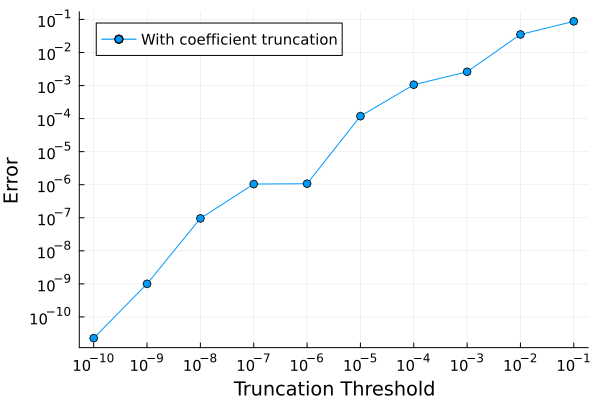

In [17]:
plot(trunc_coeffs, abs_errors, xscale=:log10, yscale=:log10, marker=:o, label="With coefficient truncation", xticks=sort(trunc_coeffs), xlabel="Truncation Threshold", ylabel="Error", yticks=10.0 .^ (-10:1:0), legend=:topleft)

A plot of truncation threshold vs error (lower is better):

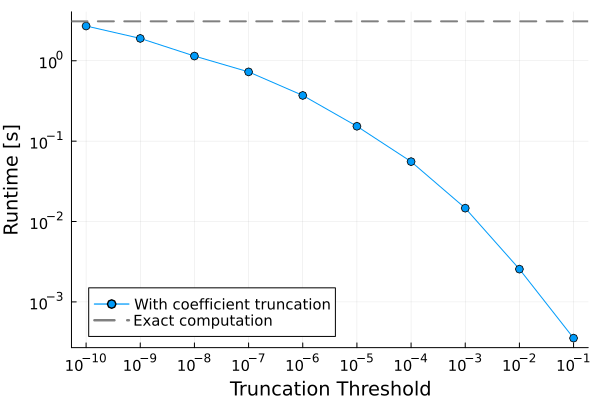

In [18]:
plot(trunc_coeffs, times, xscale=:log10, yscale=:log10, marker=:o, label="With coefficient truncation", xticks=sort(trunc_coeffs), ylabel="Runtime [s]", xlabel="Truncation Threshold", yticks=10.0 .^ (-4:1:0), legend=:bottomleft)
hline!([exact_time], color="grey", label="Exact computation", linestyle=:dash, lw=2)

And finally, plot the error against the runtime. This tells you, if you need the result to `x` accuraccy, you will need `y` time.  

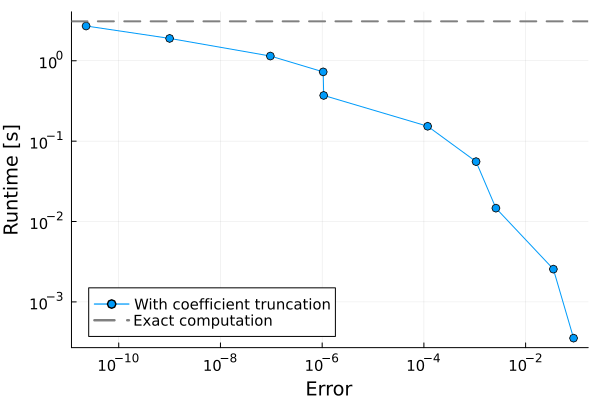

In [19]:
plot(abs_errors, times, xscale=:log10, marker=:o, yscale=:log10, label="With coefficient truncation", xticks=10.0 .^ (-10:2:0), xlabel="Error", ylabel="Runtime [s]", yticks=10.0 .^ (-4:1:0), legend=:bottomleft)
hline!([exact_time], color="grey", label="Exact computation", linestyle=:dash, lw=2)

This highlights a very important concept: There is a time vs accuracy trade-off where one can get away with orders of magnitude less computing resources compared to exact results if one is happy with a certain error. The problem: You may never know what the exact result is, and thus you won't truly know how accurate the results are. You has to check for "convergence", which is a stabilization of the result as you lower the truncation. See for example this plot of the expectation value without the exact value for reference:

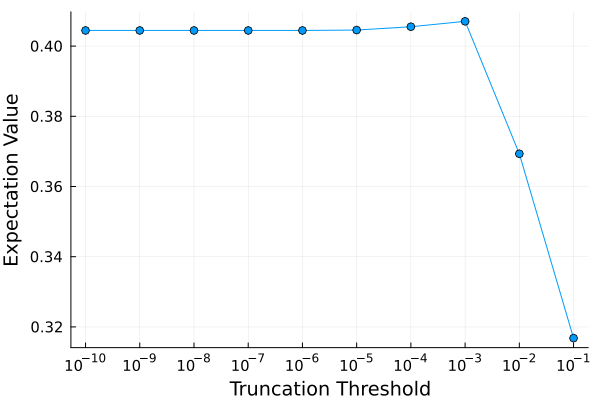

In [20]:
plot(trunc_coeffs, expectations, xscale=:log10, marker=:o, label="", xticks=sort(trunc_coeffs), xlabel="Truncation Threshold", ylabel="Expectation Value", legend=:topleft)

**An important note about this notebook:**
The runtime and errors for different combinations of observable, circuit, and initial state vary **tremedously**. Truly challening simulations may require `min_abs_coefficient` below `1e-6` or `max_weight` significantly above `10`. This will require heavy compute and perhaps new truncation rules.